In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torch.optim import Adam
from torch.utils.data import DataLoader


In [2]:
torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is use: ', device)

device is use:  cuda


# Data


In [3]:
batch_size = 256
transform = transforms.Compose([transforms.ToTensor()])

train_set = CIFAR10(
    root = './../data_cifar10',
    train= True,
    download= True,
    transform=transform,
)
val_set = CIFAR10(
    root = './../data_cifar10',
    train= False,
    download= True,
    transform=transform,
)

train_loader = DataLoader(train_set, batch_size=batch_size,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(val_set, batch_size=batch_size,
                         shuffle=False,
                         num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


# Model

Add more layer to the model

In [4]:
class CNNModel(nn.Module):
    def __init__(self, n_classes = 10):
        super(CNNModel, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, padding=1),
            nn.ReLU()
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2)
        )

        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, padding=1),
            nn.ReLU()
        )
        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, padding=1),
            nn.ReLU()
        )
        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, padding=1),
            nn.ReLU(),
        )
        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, padding=1),
            nn.ReLU(),
        )
        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, padding=1),
            nn.ReLU(),
        )
        self.conv_layer11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, padding=1),
            nn.ReLU()
        )
        self.conv_layer12 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.dense1 = nn.Sequential(
            nn.Linear(512*2*2, 512),
            nn.ReLU()
        )
        self.dense2 = nn.Linear(512, n_classes)

        self.initialize_weights()
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = self.conv_layer11(x)
        x = self.conv_layer12(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)

        return x

In [5]:
model = CNNModel(n_classes=10)
output = model(torch.rand(1,3,32,32))
model.to(device)
print(model)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_layer5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_layer6): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer7): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3),

# Train

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr= 1e-3)

In [7]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _,predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

        accuracy = 100*running_correct/total
        test_loss = test_loss / len(test_loader)
        return test_loss, accuracy

In [8]:
# parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
epochs_max = 20


In [9]:
# train
for epoch in range(epochs_max):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        # Foward, optimizer
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward propagation
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 *running_correct/total
    epoch_loss = running_loss / (i+1)

    test_loss, test_accuracy = evaluate(model, test_loader, criterion)
    print(f"Epoch [{epoch + 1}/{epochs_max}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 2.1837, Accuracy: 15.67%, Test Loss: 1.7771, Test Accuracy: 32.10%
Epoch [2/20], Loss: 1.6673, Accuracy: 36.53%, Test Loss: 1.5665, Test Accuracy: 41.60%
Epoch [3/20], Loss: 1.4197, Accuracy: 46.58%, Test Loss: 1.4021, Test Accuracy: 49.92%
Epoch [4/20], Loss: 1.2208, Accuracy: 55.28%, Test Loss: 1.1707, Test Accuracy: 57.83%
Epoch [5/20], Loss: 1.0584, Accuracy: 61.80%, Test Loss: 1.0156, Test Accuracy: 63.68%
Epoch [6/20], Loss: 0.9166, Accuracy: 66.92%, Test Loss: 0.9476, Test Accuracy: 66.11%
Epoch [7/20], Loss: 0.8089, Accuracy: 70.96%, Test Loss: 0.9023, Test Accuracy: 68.46%
Epoch [8/20], Loss: 0.7075, Accuracy: 74.89%, Test Loss: 0.7963, Test Accuracy: 72.10%
Epoch [9/20], Loss: 0.6195, Accuracy: 78.11%, Test Loss: 0.8108, Test Accuracy: 72.58%
Epoch [10/20], Loss: 0.5515, Accuracy: 80.45%, Test Loss: 0.7270, Test Accuracy: 75.88%
Epoch [11/20], Loss: 0.4899, Accuracy: 82.81%, Test Loss: 0.7432, Test Accuracy: 76.04%
Epoch [12/20], Loss: 0.4368, Accuracy: 84

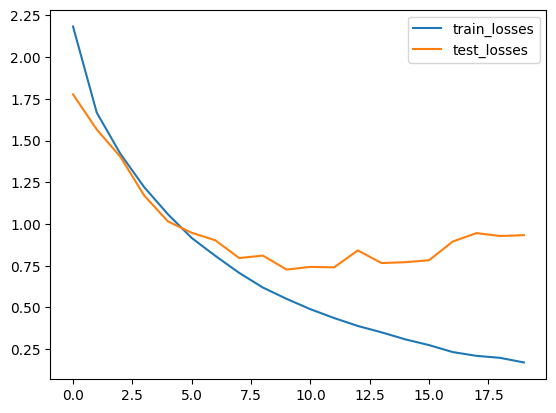

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

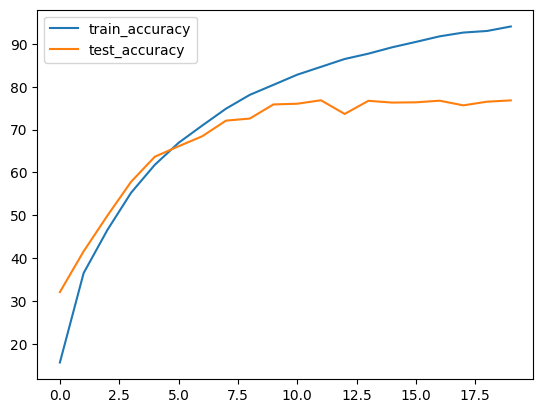

In [11]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()